# [IDEA 제공한 사이트](https://medium.com/jungle-book/towards-data-set-augmentation-with-gans-9dd64e9628e6)

## Modification Version - 2
* [google wasserstein dist 추가](https://github.com/google/wasserstein-dist/blob/master/train.py)
* variable_scope 추가
* 수정한 Loss 방식 문제 확인 후 다시 원래대로
* tf.nn.moments 를 활용하여 평균, 분산 구해서 통계량값이 맞도록 처리
* dist 시각화 및 total dist를 잴 때 생성된 값과 여러번의 샘플링 된 것과의 거리들의 평균과 표준편차를 시각화 
    * cross validation 처럼 하고 싶었음. 
    * 평균도 낮으면서(분포간 거리도 가까우면서), 다양한 샘플을 넣었을 때도 거리차이가 작기를 기대하면서
    
## Modification Version - 3
* 변수 추가
* 아직 문제점 변수가 많아졌을 때 손으래 해줘야하는 작업들이 있음
    * 어떤 변수가 Count라서 Integer로 해줘야할지? 
    * 변수별처리가 수동적임 처음 지정된 type에 굉장히 의존하게 됨.
* Col, Total Stat Loss 다시 추가 
    * Col Stat Loss에서 문제점은 Categoricla Onehot 된 것에 대한 평균 분산을 구하게 됨. ( 거기서 Loss를 nan으로 발생시킬우려가 있는 듯함)
* **추가** Categorical Loss에 Ratio를 추가
    * 각 Categorical의 도수 비율이 유사한 비율로 나오게 제한해서 생성시키는 것이 목적
* Prelu 추가
    * 아직 테스트 중 초반에는 파라미터도 같이 학습해야해서 잘 안될 것이라고 생각이 들긴함.
* 시각화
    * bins를 추가해서 Count, Categorical 변수들이 극명하게 잘 보일 수 있도록 시각화.
    
## Modification Version - 4
* Correlation Loss 수정 예정
    * Frobenius Norm 으로 변경 예정  [URL](http://mathworld.wolfram.com/FrobeniusNorm.html)
        * 좀 더 이론적임
        * 흔히 Regularization으로 사용한다고 함.
            * 기대하는 바는 상관성을 벗어나지 않으면서 생성할 수 있게 강제 할 수 있을 듯 
        * https://stackoverflow.com/questions/43917456/matrix-norm-in-tensorflow
        * 생성된 G의 Corr - R의 Corr 에서 빼면 2배가 되기때문에 한쪽만 생성할 수 있게 matrix_band_part를 사용
            * tf.matrix_band_part(input, 0, -1) ==> Upper triangular part.
            * tf.matrix_band_part(input, -1, 0) ==> Lower triangular part.
            * tf.matrix_band_part(input, 0, 0) ==> Diagonal.
    * 3차 모멘텀 추가 구현 [URL](https://en.wikipedia.org/wiki/Moment_(mathematics))
        * 모든 모멘텀이 같다면, 같은 분포다.
        * Numeric 변수에 대해서 시행
        * Skewness 역할을 한다고 함.
    * `신기한 점`
        * 현재 Numeric변수들에 대해서 처리했는데, 원래 잘 안되던 `state` 에서 고르게 생성되는 것을 확인
## Modification Version - 5
* Categorical Loss에 추가적으로 Cosine Similarity Loss 추가함.
    * 도수가 위치하는 차원이 근처에 있게?!
   * 저 빈도자체에서 크게 벗어나지 않을 것이다라고 생각해서 
    * 각 빈도를 평균으로 삼고 그러면 integer 가 되서 미분 가능하게 하기 위해 `reparameterization trick`을 적용시킨 다음에, 가깝게 매칭시키는 생각?!
 > 현재 확인하면 이 Loss는 거의 0가 안되고 있음 

## Modification Version - 7
* Modification Version - 5 에서 좀 더 확장해서 생각을 해본 것이 빈도수를 평균이라 가정하고 그 주변에서 발생할거라고 생각
* 그리고 그 것들에 대한 KL Divergence를 구해서 Loss 떨어트리기
 
 ## Modification Version - 8
 * 새로운 데이터 `Pokemon`에 접목 
     * 일단 쌍봉인 것도 있고, `total` 변수같이 다른 변수의 합으로 파생되서 나오는 것들에 대해서 확인할 필요가 있어서 시도
 * **Missing 처리**
     * Categorical 에 대해서 결측치 처리 하나의 변수를 추가해서 함
 

In [101]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets , sys
from sklearn.preprocessing import MinMaxScaler
sys.path.append('/home/advice/Python/SR/Custom/')
from jupyter_tensorboard import *
from utility import *
from Init import *
from wasserstein import Wasserstein
from IPython.display import clear_output
import os , re

import warnings
warnings.filterwarnings("ignore")

usecol = ['type1', 'type2', 'ability1',
       'ability2', 'abilityH', 'hp', 'attack', 'defense', 'spattack',
       'spdefense', 'speed', 'total', 'weight', 'height',
       'class', 'percent-male', 'percent-female', 'pre-evolution',
       'egg-group1', 'egg-group2']

pokemon = pd.read_csv("./../Data/Pokemon/pokemon.csv" , usecols = usecol)
#
## .str.replace('lbs.', '').astype(float)
pokemon["weight(kg)"] = \
pokemon["weight"].map(lambda x : float(re.sub('lbs.', '' , x )) * 0.453592)
pokemon["height(cm)"] = \
pokemon["height"].map(lambda x : round( 2.54 * (float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[0])*12 + float(re.sub(r'[^A-Za-z0-9]+', ' ' , x ).split(" ")[1])  ) , 1 ))

pokemon.drop(["height" , "weight" ,  ], axis = 1 , inplace= True)
## https://www.w3resource.com/python-exercises/python-basic-exercise-59.php
#

In [102]:
a = pokemon[["percent-male", "percent-female"]].dropna(axis = 0).drop_duplicates()
b = 1- a 
c = pd.merge(a,b, how='outer')

In [103]:
import pandas_profiling
if os.path.isfile("pokemon_profiling.html")  :
    pass
else :
    profile = pokemon.profile_report(title='pokemon Profiling Report')
    profile.to_file(output_file="pokemon_profiling.html")

In [105]:
print(pokemon.shape)
#pokemon.dropna(axis = 0 , subset=["percent-male", "percent-female"] , inplace= True )
### 1 - percent-female =  percent_male
## 치환만 해주면 되는 거라서! 
pokemon = pokemon.fillna("NULL")
pokemon[["percent-male", "percent-female"]] = pokemon[["percent-male", "percent-female"]].astype(object)
replace_gender = pokemon[["percent-male", "percent-female"]].drop_duplicates()
c = c.astype(object)
replace_gender = pd.merge(c,replace_gender, how='outer').values.astype(str)

(1061, 20)


In [106]:
replace_gender = dict(zip(replace_gender[:,0] , replace_gender[:,1]))
replace_gender

{'0.875': '0.125',
 '0.5': '0.5',
 '0.0': '1.0',
 '1.0': '0.0',
 '0.25': '0.75',
 '0.75': '0.25',
 '0.125': '0.875',
 'NULL': 'NULL'}

In [97]:
pokemon.drop(["percent-male" , "total"], axis = 1 , inplace= True)
print(pokemon.shape)

(1061, 18)


In [52]:
replace_gender

{'0.875': '0.125',
 '0.5': '0.5',
 '0.0': '1.0',
 '1.0': '0.0',
 '0.25': '0.75',
 '0.75': '0.25',
 'NULL': 'NULL'}

In [4]:
#pokemon[["type1" , "type2" ]].groupby([pokemon["ability1"] , pokemon["ability2"] , pokemon["abilityH"]]).count()
pokemon.pivot_table(values='abilityH', index =['type1' ],columns= ["type2"] ,aggfunc='count' , fill_value= 0 )

type2,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,NULL,Normal,Poison,Psychic,Rock,Steel,Water
type1,,,,,,,,,,,,,,,,,,,
Bug,0,0,0,5,2,4,2,32,1,6,2,0,23,0,12,0,3,11,3
Dark,0,0,4,0,0,3,3,5,2,0,0,2,15,3,0,2,0,2,0
Dragon,0,0,0,1,1,3,1,6,0,0,9,3,14,0,0,4,0,0,0
Electric,0,0,0,0,2,0,1,6,1,1,0,1,37,2,0,1,0,4,1
Fairy,0,0,0,0,0,0,0,2,0,0,0,0,32,0,0,0,0,0,0
Fighting,0,0,0,0,0,0,0,1,1,0,0,1,23,0,0,3,0,2,0
Fire,0,1,2,0,0,7,0,7,1,0,3,0,33,2,0,2,1,1,1
Flying,0,0,2,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0
Ghost,0,0,2,0,4,0,3,3,0,11,2,0,13,0,4,0,0,0,0


In [5]:
pokemon.columns.tolist()

['type1',
 'type2',
 'ability1',
 'ability2',
 'abilityH',
 'hp',
 'attack',
 'defense',
 'spattack',
 'spdefense',
 'speed',
 'class',
 'percent-female',
 'pre-evolution',
 'egg-group1',
 'egg-group2',
 'weight(kg)',
 'height(cm)']

In [6]:
Real = pokemon.copy()
Real["percent-female"] = Real["percent-female"].astype(str)

In [7]:
39 + 52 + 43 + 60 + 50 + 65

309

In [8]:
Real.head()

,type1,type2,ability1,ability2,abilityH,hp,attack,defense,spattack,spdefense,speed,class,percent-female,pre-evolution,egg-group1,egg-group2,weight(kg),height(cm)
0,Grass,Poison,Overgrow,NULL,Chlorophyll,45,49,49,65,65,45,Seed Pokémon,0.125,NULL,Monster,Grass,6.894598,71.1
1,Grass,Poison,Overgrow,NULL,Chlorophyll,60,62,63,80,80,60,Seed Pokémon,0.125,Bulbasaur,Monster,Grass,13.018090,99.1
2,Grass,Poison,Overgrow,NULL,Chlorophyll,80,82,83,100,100,80,Seed Pokémon,0.125,Ivysaur,Monster,Grass,100.017036,200.7
3,Fire,NULL,Blaze,NULL,Solar Power,39,52,43,60,50,65,Lizard Pokémon,0.125,NULL,Monster,Dragon,8.482170,61.0
4,Fire,NULL,Blaze,NULL,Solar Power,58,64,58,80,65,80,Flame Pokémon,0.125,Charmander,Monster,Dragon,19.005505,109.2


In [9]:
Real["percent-female"].unique()

array(['0.125', '0.5', '1.0', '0.0', '0.75', '0.25', 'NULL'], dtype=object)

https://stackoverflow.com/questions/21271581/selecting-pandas-columns-by-dtype

```
## all float 
df.select_dtypes(include=['floating'])
## all integer
df.select_dtypes(include=['integer'])
## all numeric
df.select_dtypes(include=['number'])
## select
[col for col in df.columns.tolist() if df[col].dtype not in ['object','<M8[ns]']]
```

In [10]:
Real.dtypes

type1              object
type2              object
ability1           object
ability2           object
abilityH           object
hp                  int64
attack              int64
defense             int64
spattack            int64
spdefense           int64
speed               int64
class              object
percent-female     object
pre-evolution      object
egg-group1         object
egg-group2         object
weight(kg)        float64
height(cm)        float64
dtype: object

## PostProcessing


* Numeric
    * Inverse Transform을 진행해서 원래 분포의 범위로 변환시켜주기
    * **integer**
        * count variable 같은 경우 round로 정수형으로 처리해주기?
    * **numeric**
        * 그대로 사용해도 가능 할 듯
* Categorical
    * softmax로 나오므로 argmax 처리하고, 분포를 보여줄때는 수치형으로 보여주고 사용할 때는 변환하는 방식
    * 일단 그림을 그릴 때는 그대로 사용하면 될 듯

In [11]:
Real.head()

,type1,type2,ability1,ability2,abilityH,hp,attack,defense,spattack,spdefense,speed,class,percent-female,pre-evolution,egg-group1,egg-group2,weight(kg),height(cm)
0,Grass,Poison,Overgrow,NULL,Chlorophyll,45,49,49,65,65,45,Seed Pokémon,0.125,NULL,Monster,Grass,6.894598,71.1
1,Grass,Poison,Overgrow,NULL,Chlorophyll,60,62,63,80,80,60,Seed Pokémon,0.125,Bulbasaur,Monster,Grass,13.018090,99.1
2,Grass,Poison,Overgrow,NULL,Chlorophyll,80,82,83,100,100,80,Seed Pokémon,0.125,Ivysaur,Monster,Grass,100.017036,200.7
3,Fire,NULL,Blaze,NULL,Solar Power,39,52,43,60,50,65,Lizard Pokémon,0.125,NULL,Monster,Dragon,8.482170,61.0
4,Fire,NULL,Blaze,NULL,Solar Power,58,64,58,80,65,80,Flame Pokémon,0.125,Charmander,Monster,Dragon,19.005505,109.2


In [12]:
float_name = Real.select_dtypes(include= ["float"]).columns.tolist()
float_name

['weight(kg)', 'height(cm)']

In [13]:
Real.select_dtypes(include= ["number"]).columns.tolist()

['hp',
 'attack',
 'defense',
 'spattack',
 'spdefense',
 'speed',
 'weight(kg)',
 'height(cm)']

In [14]:
Int_name = Real.select_dtypes(include= ["integer"]).columns.tolist()
object_name = Real.select_dtypes(exclude= ["number"]).columns.tolist()
numeric_name = Real.select_dtypes(include= ["number"]).columns.tolist()
print("OBJECT : ", object_name)
print("NUMERIC : " ,numeric_name)
print("Int : ",Int_name)
print("float : ", float_name )
assert len(Int_name) + len(float_name) == len(numeric_name) , "개수가 일치 하지 않음 체크 필요함!!"

OBJECT :  ['type1', 'type2', 'ability1', 'ability2', 'abilityH', 'class', 'percent-female', 'pre-evolution', 'egg-group1', 'egg-group2']
NUMERIC :  ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed', 'weight(kg)', 'height(cm)']
Int :  ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed']
float :  ['weight(kg)', 'height(cm)']


In [15]:
Real = Real[numeric_name + object_name]

In [16]:
feature = Real.columns.tolist()

In [17]:
total_length = 0 
info = {}
for i in object_name :
    value = Real[i].nunique()
    info[i] = value
    total_length += value
    
total_length += len(numeric_name)
print(total_length)
print(info)

1545
{'type1': 18, 'type2': 19, 'ability1': 184, 'ability2': 150, 'abilityH': 163, 'class': 587, 'percent-female': 7, 'pre-evolution': 379, 'egg-group1': 16, 'egg-group2': 14}


In [18]:
data = Real.values
def sample_data(n= len(data) , data = None) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

In [19]:
input_dim = np.shape(data)[1] 
latet_dim = 100

def parametric_relu(_x):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1],
                       initializer=tf.constant_initializer(0.0),
                        dtype=tf.float32)
    pos = tf.nn.relu(_x)
    neg = alphas * (_x - abs(_x)) * 0.5
    return pos + neg

def generator(Z , batch_size , hsize=[ 200, 300 , 700],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        #h1 = tf.layers.dense(Z,hsize[0], activation = parametric_relu )
        h1 = tf.layers.dense(Z,hsize[0]  , activation = None )
        h2 = tf.layers.dense(h1,hsize[1]-15,activation=parametric_relu , use_bias=True)
        h2 = tf.layers.dense(h2,hsize[1]-15,activation=None) 
        h2 = tf.layers.dense(h2,hsize[1],activation= parametric_relu , use_bias=True )
        h2 = tf.layers.dense(h1,hsize[1],activation=None) 
        h2 = tf.layers.dense(h2, hsize[2] , activation = tf.nn.leaky_relu , use_bias=True )  
        #num = tf.slice(h2 , [0,0] , [BATCH_SIZE, 22] )  # 
        #cat = tf.slice(h2 , [0,22] , [BATCH_SIZE, 3] ) # 
        out = tf.layers.dense(h2,  total_length , activation = None , use_bias= True )
        num = tf.slice(out , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        first = tf_sqnl(num)
        ## Categorcial 
        NUM = 0
        for i in object_name :
            cat = tf.slice(out , [0,len(numeric_name) + NUM ] , [batch_size , info.get(i)] ) # 
            Species = tf.nn.softmax(cat)
            NUM += info.get(i)
            first = tf.concat([first , Species], axis = 1 , name = i[0] )
        #out = tf.layers.dense(num ,input_dim , activation = tf_sqnl , use_bias=False , name = 'Numerical' )  # activation=None 
    return first


def discriminator(X,hsize=[200, 100],reuse=True):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu , name = "D1")
        #h1 = minibatch(h1 , name = "D1")
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu , name = "D2" )
        h2 = minibatch(h2 , name = "D2")
        h3 = tf.layers.dense(h2,10 ,activation=tf.nn.leaky_relu , name = "D3" )
        #h3 = minibatch(h3 , name = "D3")
        out = tf.layers.dense(h3,1) # activation=None OUTPUT
    return out, h3

def sample_Z(m , n ):
    return np.random.uniform(-1., 1., size=[m , n])


In [20]:
input_dim

18

In [21]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None, total_length  ], name= "X")
Z = tf.placeholder(tf.float32,[None,latet_dim ] , name = "Z")
batch_size = tf.placeholder(tf.int64, name="Batchsize")

In [22]:
EPOCHS = 200000
BATCH_SIZE = 100
data_len = np.shape(data)[0]
batch_iter = int(data_len / BATCH_SIZE)

dataset = tf.data.Dataset.from_tensor_slices((X, Z)).batch(batch_size , drop_remainder=True ).repeat().shuffle(1000)
iter = dataset.make_initializable_iterator()
x , z = iter.get_next()

print(batch_iter)

Instructions for updating:
Colocations handled automatically by placer.
10


In [23]:
G_sample = generator(z , batch_size)
r_logits, r_rep = discriminator(x,reuse=False)
f_logits, g_rep = discriminator(G_sample,reuse=True)

# e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
# x_hat =  e * x + (1-e) * G_sample
# grad  = tf.gradients( discriminator(x_hat,reuse=True ), x_hat)[0]

#grad_norm = tf.norm( tf.layers.flatten(grad) , axis = 1)
#LP = 10 * tf.reduce_mean( tf.square( tf.maximum(0.0 ,grad_norm - 1.0)))


# slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
# gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

Instructions for updating:
Use keras.layers.dense instead.


In [24]:
def moment(x = None , nth = 3) :
    """Column 별 3차 모멘트 계산"""
    standard = tf.div(x - tf.reduce_mean(x, axis = 0) , tf.math.reduce_std(x , axis = 0))
    pow_3 = tf.pow(standard ,nth )
    three_moment = tf.reduce_mean(pow_3 , axis = 0)
    return three_moment

In [25]:
# fake_logit = (f_logits - tf.reduce_mean(r_logits))
# real_logit = (r_logits - tf.reduce_mean(f_logits))
# real_logit = tf.sigmoid( real_logit )
# fake_logit = tf.sigmoid( fake_logit )
# disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
# gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))


# disc_loss = tf.reduce_mean(
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + 
#     tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)) , name = "discriminator_loss")
# gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)), name= "generator_loss")

## wgan Loss 변경
### 이유 : 이전에는 이미지다보니 2D 전체를 하는 것이 맞지만, 테이블 데이터 같은 경우에는 열별로 비교해야할듯하다.
### 이유2 : 전체적인 것도 고려할 수 있게하기! 
e = tf.random_uniform([BATCH_SIZE , 1] , 0 , 1)
x_hat =  e * x + (1-e) * G_sample
grad  = tf.gradients( discriminator(x_hat, reuse=True ), x_hat)[0]
slopes = tf.sqrt(1e-8 + tf.reduce_sum(tf.square(grad), axis=[1]))
gradient_penalty = 5 * tf.reduce_mean((slopes - 1.) ** 2)

fake_logit = (f_logits - tf.reduce_mean(r_logits))
real_logit = (r_logits - tf.reduce_mean(f_logits))
real_logit = tf.sigmoid( real_logit )
fake_logit = tf.sigmoid( fake_logit )

with tf.variable_scope("Discriminator_Loss") :        
#     total_disc_loss = tf.reduce_mean(f_logits) - tf.reduce_mean(r_logits)     
#     col_disc_loss = tf.reduce_sum(tf.reduce_mean(f_logits , axis = 0 ) - tf.reduce_mean(r_logits , axis = 0  ))
#     ratio = 1.0
#     disc_loss = ratio * total_disc_loss + (1-ratio) * col_disc_loss 
    disc_loss = - tf.reduce_mean( log(real_logit)) - tf.reduce_mean( log(1-fake_logit ))
    disc_loss += gradient_penalty

## 기존 wgan loss
#disc_loss = tf.reduce_mean(f_logits  ) - tf.reduce_mean(r_logits  ) + gradient_penalty
#gen_loss  = - tf.reduce_mean(f_logits)


## Numeric 변수에 대한 Correlation Loss 추가
### 이유는 상관관계가 유사하게 나와야 하기 때문에 규제를 주는 역할을 기대할 수 있다!
### Generator Loss에 넣어서 Generator에서만 Weight 조절할수 있게! 
def tf_cov(x):
    mean_x = tf.reduce_mean(x, axis=0, keep_dims=True)
    mx = tf.matmul(tf.transpose(mean_x), mean_x)
    vx = tf.matmul(tf.transpose(x), x)/tf.cast(tf.shape(x)[0], tf.float32)
    cov_xx = vx - mx
    return cov_xx
def kl_divergence_gaussians(q_mu, q_sigma, p_mu, p_sigma) :
    r = q_mu - p_mu
    return tf.reduce_sum( log(p_sigma) - log(q_sigma) - .5 * (1. - (q_sigma**2 + r**2) / p_sigma**2), axis=-1)

def Differ_Round(x) :
    ## https://stackoverflow.com/questions/46596636/differentiable-round-function-in-tensorflow
    differentiable_round = tf.maximum(x-0.499,0)
    differentiable_round = differentiable_round * 10000
    differentiable_round = tf.minimum(differentiable_round, 1)
    return differentiable_round

with tf.variable_scope("Generator_Loss"):
    with tf.variable_scope("Original_Loss"):
        gen_loss = - tf.reduce_mean( log( fake_logit )) - tf.reduce_mean( log(1- real_logit ))
        #gen_loss  = - tf.reduce_mean(f_logits)
        # -tf.reduce_sum(tf.reduce_mean(f_logits , axis = 0 ))
    with tf.variable_scope("Corr_Loss"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        num_R = tf.slice(x , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        matrix = tf_cov(num_G) - tf_cov(num_R)
        Upper_triangular = tf.matrix_band_part(matrix, 0, -1)
        corr_loss = tf.reduce_sum(tf.square( Upper_triangular ))        
    tf.summary.scalar("Corr_loss", corr_loss)
    gen_loss += 2 * corr_loss
    with tf.variable_scope("wasserstein_Loss"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        cat_G = tf.slice(G_sample , [0, len(numeric_name)] , [batch_size,  -1 ] )  # 
        Round_G = Differ_Round(cat_G)
        Processing_G = tf.concat([num_G , Round_G] , axis = 1 )
        wasserstein = Wasserstein(Processing_G  , x , BATCH_SIZE)
        loss = wasserstein.dist(C=0.1, nsteps=10)
    tf.summary.scalar("wasserstein_loss", loss)
    gen_loss += loss
    with tf.variable_scope("Stat"):
        Gcol_mean , Gcol_var = tf.nn.moments(G_sample , axes = [0])
        Xcol_mean , Xcol_var = tf.nn.moments(x , axes = [0])
        G_mean , G_var = tf.nn.moments(G_sample , axes = [0,1])
        X_mean , X_var = tf.nn.moments(x , axes = [0,1])
        Colstat = tf.reduce_mean(tf.square(Gcol_mean - Xcol_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(Gcol_var) - tf.sqrt(Xcol_var)))
        Totalstat = tf.reduce_mean(tf.square(G_mean - X_mean)) \
        + tf.reduce_mean(tf.square( tf.sqrt(G_var) - tf.sqrt(X_var)))
        ## 추가 빈도 비율이 유사하게 되지 않을까!?
    with tf.variable_scope("Categorical_Ratio"):
        cat_G = tf.slice(G_sample , [0, len(numeric_name)] , [batch_size,  -1 ] )  # 
        cat_R = tf.slice(x , [0,  len(numeric_name)] , [batch_size,  -1] )  # 
        Round_G = tf.reduce_sum(Differ_Round(cat_G) , axis = 0 )
        Round_R = tf.reduce_sum(Differ_Round(cat_R) , axis = 0 )
        D = tf.shape(cat_R)[1]
        q_sigma = tf.ones(D) * 2.0
        p_sigma = tf.ones(D) * 2.0
        KL_LOSS = tf.reduce_sum(tf.distributions.kl_divergence(
            tf.distributions.Normal(loc=Round_G, scale=q_sigma),
            tf.distributions.Normal(loc=Round_R, scale=p_sigma)), axis=-1)
        
        """
        제한은 주지만, 너무 Loss가 크게 의존하지는 않게,
        """
        Cat_Ratio = tf.reduce_mean( tf.square(Round_G - Round_R) ) * 0.5
        normalize_a = tf.nn.l2_normalize(Round_G,0)        
        normalize_b = tf.nn.l2_normalize(Round_R,0)
        cos_similarity=tf.reduce_sum(tf.multiply(normalize_a,normalize_b))
        Similarity_Loss = 1 * cos_similarity
    tf.summary.scalar("Categorical_Ratio_loss", Cat_Ratio)
    tf.summary.scalar("Colstat_loss", Colstat)
    tf.summary.scalar("Totalstat_loss", Totalstat)
    tf.summary.scalar("Similarity_loss", Similarity_Loss)
    tf.summary.scalar("Categorical_KL_loss", KL_LOSS)
    gen_loss +=  Totalstat + Cat_Ratio + Similarity_Loss + KL_LOSS
    with tf.variable_scope("Moment"):
        num_G = tf.slice(G_sample , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        num_R = tf.slice(x , [0,0] , [batch_size,  len(numeric_name) ] )  # 
        Diff_3 = moment(num_G,3) - moment(num_R,3)
        three_moment_diff = tf.reduce_sum(tf.square(Diff_3))
        Diff_4 = moment(num_G,4) - moment(num_R,4)
        four_moment_diff = tf.reduce_sum(tf.square(Diff_4))
    tf.summary.scalar("3th_moment", three_moment_diff)
    tf.summary.scalar("4th_moment", four_moment_diff)
    gen_loss += three_moment_diff + four_moment_diff
    # Colstat +
    


tf.summary.scalar("Dloss", disc_loss)
tf.summary.scalar("Gloss", gen_loss)

t_vars = tf.trainable_variables()

for var in t_vars :
    tf.summary.histogram(var.op.name, var)

global_step = tf.get_variable('global_step', [], initializer=tf.constant_initializer(0), trainable=False)
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")
lr = 0.001
learning_rate = tf.train.exponential_decay(lr, global_step, decay_steps=100, decay_rate=0.998, staircase=True , )

tf.summary.scalar("learning_rate", learning_rate)
with tf.variable_scope("Optimizer"):
    gen_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(gen_loss,var_list = gen_vars) # G Train step
    disc_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(disc_loss,var_list = disc_vars) # D Train step
    

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [26]:
tensorboard()

In [27]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
merged_summary = tf.summary.merge_all()
sess = tf.Session(config= config)
saver = tf.train.Saver()

suumary_dir = "/home/advice/Python/SR/board/Gan_Pokemon_v1"
img_dir = "./Gan_Pokemon_v1"
try :
    if tf.gfile.Exists(suumary_dir):
        tf.gfile.DeleteRecursively(suumary_dir)
        tf.gfile.MakeDirs(suumary_dir)
        tf.gfile.DeleteRecursively(img_dir)
        tf.gfile.MakeDirs(img_dir)
except Exception as e :
    tf.gfile.MakeDirs(img_dir)
tf.gfile.MakeDirs(img_dir)
    
writer = tf.summary.FileWriter(suumary_dir)
writer.add_graph(sess.graph )
tf.global_variables_initializer().run(session=sess)

In [28]:
load_model = False
if load_model == True :
    print("학습된 모델 사용하기")
    save_file = "./savemodel/gan.meta"
    saver = tf.train.import_meta_graph(save_file)
    saver.restore(sess, tf.train.latest_checkpoint('./savemodel/'))
else :
    print("처음부터 학습시키기")

처음부터 학습시키기


## DATA Preprocessing

In [29]:
original = data.copy()
transform = original.copy()

In [30]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
##
TOTAL = data[:,:len(numeric_name)]
onehot_bin = []
value2code = {}
code2value = {}
for i in range(len(numeric_name) , np.shape(data)[1]) :
    print(feature[i])
    label_encoder.fit(data[:,i])
    keys = label_encoder.classes_.tolist()
    value2code[feature[i]] = dict(zip(keys , np.arange(len(keys))))
    code2value[feature[i]] = dict(zip(np.arange(len(keys)), keys))
    encoding = label_encoder.transform(data[:,i])
    onehot_encoder.fit(np.array(encoding).reshape(-1,1))
    cat = onehot_encoder.transform(np.array(encoding).reshape(-1,1))
    onehot_bin.append(TOTAL.shape[1])
    before = TOTAL.shape[1]
    TOTAL = np.concatenate((TOTAL , cat) , axis = 1 )
    print("{} 위치[{}] : {}:{}".format(feature[i], i , before  , TOTAL.shape[1] +1 ))
    transform[:,i] = label_encoder.transform(transform[:,i])

type1
type1 위치[8] : 8:27
type2
type2 위치[9] : 26:46
ability1
ability1 위치[10] : 45:230
ability2
ability2 위치[11] : 229:380
abilityH
abilityH 위치[12] : 379:543
class
class 위치[13] : 542:1130
percent-female
percent-female 위치[14] : 1129:1137
pre-evolution
pre-evolution 위치[15] : 1136:1516
egg-group1
egg-group1 위치[16] : 1515:1532
egg-group2
egg-group2 위치[17] : 1531:1546


In [99]:
replace_gender

{0.875: 0.125,
 0.5: 0.5,
 0.0: 1.0,
 1.0: 0.0,
 0.25: 0.75,
 0.75: 0.25,
 0.125: 0.875,
 'NULL': 'NULL'}

In [110]:
value2code["percent-female"]

{'0.0': 0, '0.125': 1, '0.25': 2, '0.5': 3, '0.75': 4, '1.0': 5, 'NULL': 6}

['0.125',
 '0.125',
 '0.125',
 '0.125',
 '0.125',
 '0.125',
 '0.125',
 '0.125',
 '0.125',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '1.0',
 '1.0',
 '1.0',
 '0.0',
 '0.0',
 '0.0',
 '0.75',
 '0.75',
 '0.75',
 '0.75',
 '0.75',
 '0.75',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.25',
 '0.25',
 '0.5',
 '0.5',
 '0.5',
 '0.25',
 '0.25',
 '0.25',
 '0.25',
 '0.25',
 '0.25',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 'NULL',
 'NULL',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 'NULL',
 'NULL',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.0',
 '0.0',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 '1.0',
 '0.5',
 '1.0',
 '0.5',
 '0.5',
 '0.5',
 '0.5',
 'NULL',
 'N

In [31]:
data= TOTAL
del TOTAL
onehot_bin += [data.shape[1]]
print(onehot_bin)

[8, 26, 45, 229, 379, 542, 1129, 1136, 1515, 1531, 1545]


In [32]:
np.bincount(np.argmax(data[:,995:1002] , axis = 1)).sum()

1061

In [33]:
x_plot = sample_data(n= 500 , data = transform ).astype(float) # len(data)
x_plot.shape

(500, 18)

In [34]:
# x_plot2 = x_plot[:,:len(numeric_name)].copy()
# for idx , i in enumerate(onehot_bin[:-1]) :
#     x_plot2 = np.concatenate( (x_plot2 ,
#                                np.argmax(x_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ] , 1 )[:,np.newaxis] ) , axis = 1 )
# x_plot = x_plot2
# del x_plot2

In [35]:
print("Numeric NAME : {}".format(numeric_name))

Numeric NAME : ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed', 'weight(kg)', 'height(cm)']


In [36]:
from scipy.stats import wasserstein_distance as was_dist
nd_steps = 1
ng_steps = 1
save_model = True
scaler = MinMaxScaler(feature_range=(-1. ,1.))
## 표준화로 해보기!
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
data[:,:len(numeric_name)] = scaler.fit_transform(data[:,:len(numeric_name)])

In [37]:
data.shape

(1061, 1545)

In [38]:
x_plot.shape

(500, 18)

({0: '0.0', 1: '0.125', 2: '0.25', 3: '0.5', 4: '0.75', 5: '1.0', 6: 'NULL'},
 {0.875: 0.125,
  0.5: 0.5,
  0.0: 1.0,
  1.0: 0.0,
  0.25: 0.75,
  0.75: 0.25,
  'NULL': 'NULL'},
 {'0.0': 0, '0.125': 1, '0.25': 2, '0.5': 3, '0.75': 4, '1.0': 5, 'NULL': 6})

In [122]:
def main() :
    imgs = []
    Total_ws = pd.DataFrame({"iter":[0] , "ws" :[0], "wstd" : [0]})
    for i in range(EPOCHS) : 
        z_batch = sample_Z(data_len , latet_dim )
        sess.run(iter.initializer, feed_dict={ X : data , 
                                              batch_size: BATCH_SIZE , 
                                              Z : z_batch  ,
                                             })
        #for _ in range( batch_iter)  :
        nd_steps = 2
        for _ in range(nd_steps):
            _, dloss  = sess.run([disc_step, disc_loss] , feed_dict={global_step : i ,
                                                                     batch_size : BATCH_SIZE
                                                                    })
        #writer.add_summary(summary, global_step=i)
        ng_steps = 2
        for _ in range(ng_steps):
            _, gloss = sess.run([gen_step, gen_loss], feed_dict={global_step : i , 
                                                                 batch_size : BATCH_SIZE
                                                                })
        #writer.add_summary(summary, global_step = i)

        if i% 100 == 0 :
            try :
                _ , _ , _ , _ , summary_str = sess.run([disc_step , gen_step , disc_loss , gen_loss , merged_summary] , 
                                                       feed_dict = {global_step : i ,
                                                                    batch_size : BATCH_SIZE
                                                                   })
                writer.add_summary(summary_str , global_step = i)
            except Exception as e :
                pass 

            if save_model == True :
                saver.save(sess, './savemodel/gan')
            clear_output(wait= True)
            generate_n = 500
            z_batch = sample_Z(generate_n  , latet_dim )
            g_plot = sess.run(G_sample , feed_dict = {z : z_batch , batch_size : generate_n})
            g_plot[:,:len(numeric_name)] = scaler.inverse_transform(g_plot[:,:len(numeric_name)])
            g_numeric = g_plot[:,:len(numeric_name)]
            for idx , _ in enumerate(onehot_bin[:-1]) :
                cat = np.argmax(g_plot[:, onehot_bin[idx] : onehot_bin[idx+1] ], 1 )
                g_numeric = np.concatenate((g_numeric ,cat[:,np.newaxis] ) , axis = 1 )
            g_plot = g_numeric
            del g_numeric
            print(np.array(g_plot).shape)
            """
            시각화 
            """
            fig, ax = plt.subplots(4,5, figsize=(18, 12))
            fig.subplots_adjust(hspace = 0.35 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
            axx = ax.flatten()
            num = 0
            total_dist = 0 
            ## total 변수 
            total_var = 0
            g_total_var = 0
            for n , name in enumerate(feature) :
                try :
                    total_dist += was_dist(x_plot[:,n], g_plot[:,n])
                except Exception as e :
                    pass
                """
                bin count 비교
                """
                import collections
                from collections import Counter
                
                if name in object_name  :
                    print(name)
                    print("gene -----------")
                    print(np.bincount( np.array(g_plot[:,n]).astype(int) ) )
                    print("true -----------")
                    print(np.bincount( np.array(x_plot[:,n]).astype(int) ) )
                    print("-----------------")
                """
                Visualization
                """
                ## object 
                if name in object_name  :
                    binsize = len(np.unique(x_plot[:,n].astype(float) ))
                    if name == "percent-female" :
                        
                        Real_MALE = [code2value[name][letter] for letter in x_plot[:,n].astype(float) ]
                        Gene_MALE = [code2value[name][letter] for letter in g_plot[:,n].astype(float) ]
                    sns.distplot(x_plot[:,n].astype(float) , kde = False ,  
                                 hist_kws ={"color":"r", "label" : "Real"} ,  
                                 bins = binsize ,
                                 rug = True , ax = axx[num])
                    sns.distplot(g_plot[:,n],  kde = False ,  
                                 hist_kws ={"color":"g" , "label" : "Gene"} ,
                                 bins = binsize , 
                                 rug = True   , ax = axx[num])
                ## numeric
                else :
                    ## numeric_int
                    if name in Int_name  : 
                        Real  = x_plot[:,n].astype(float).round(0)
                        Fake  = g_plot[:,n].round(0)
                        binsize= len(np.unique(Real))
                        sns.distplot(Real  , kde_kws ={"color": "r", "label" : "Real"} , bins = binsize ,
                                     hist_kws ={"color":"r"}, ax = axx[num])
                        sns.distplot(Fake , kde_kws ={"color": "g", "label" : "Gene"} , bins = binsize ,
                                     hist_kws ={"color":"g"}, ax = axx[num])
                    ## numeric_float
                    else :
                        Real  = x_plot[:,n].astype(float)
                        Fake  = g_plot[:,n]
                        ## 사후 전처리 
                        for name in ['hp', 'attack', 'defense', 'spattack', 'spdefense', 'speed'] :
                            total_var += Real
                            g_total_var += Fake
                        sns.distplot(Real  , kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
                        sns.distplot(Fake , kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
                axx[num].set_title("{}".format(name))
                num +=1
            for name_2 in ["total", "percent-male"] :
                if name_2 == "total" :
                    sns.distplot(total_var  , kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
                    sns.distplot(g_total_var , kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
                elif name_2 == "percent-male" :
                    Real_ = [replace_gender[letter] for letter in Real_MALE ]
                    Gene_ = [replace_gender[letter] for letter in Gene_MALE ]
                    
                    
                    Real_ = [ male if male == "NULL" else str(1-male.astype(float)) for male in Real_ ]
                    
                    Gene_ = [ male if male == "NULL" else str(1-male.astype(float)) for male in Gene_ ]
                    print("Gene----")
                    print(collections.Counter(Gene_))
                    print("Real----")
                    print(collections.Counter(Real_))
                    label_encoder.fit(Real_)
                    R_Male = label_encoder.transform(Real_ )
                    G_Male = label_encoder.transform(Gene_ )
                    binsize = len(np.unique(R_Male.astype(float) ))
                    sns.distplot(R_Male.astype(float) , kde = False ,  
                                 hist_kws ={"color":"r", "label" : "Real"} ,  
                                 bins = binsize ,
                                 rug = True , ax = axx[num])
                    sns.distplot(G_Male ,  kde = False ,  
                                 hist_kws ={"color":"g" , "label" : "Gene"} ,
                                 bins = binsize , 
                                 rug = True   , ax = axx[num])
                axx[num].set_title("{}".format(name_2))
                num +=1
            
            plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
            plt.savefig( img_dir + '/iteration_%d.png'%i)
            imgs.append( img_dir + '/iteration_%d.png'%i)
            ## 쓸모없는 것 제거 
            plt.show()
            total_dist = []
            for _ in range(10) :
                sampling = sample_data(n= generate_n , data = transform).astype(float) # len(data)
                dist = 0
                for col in range(len(feature)) :
                    try :
                        dist += was_dist(sampling[:,col], g_plot[:,col])
                    except Exception as e :
                        ## Penalty
                        dist += 100
                        pass
                total_dist.append(dist)
            total_std = np.std(total_dist)
            total_dist = np.mean(total_dist)
            iter_ws = pd.DataFrame({"iter":[i] , "ws" :[total_dist] , "wstd" : [total_std]})
            Total_ws    = Total_ws.append(iter_ws)
            fig , ax = plt.subplots(figsize = (26,13))
            fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)
            Total_ws = Total_ws[Total_ws.iter > 0 ]
            ax.plot(Total_ws["iter"] , Total_ws["ws"] , linestyle ="-" , marker ="." , linewidth = 3, markersize = 12)
            ax.plot(Total_ws["iter"] , Total_ws["ws"]-1.96*Total_ws["wstd"] , linestyle ="dashed"  , linewidth = 1)
            ax.plot(Total_ws["iter"] , Total_ws["ws"]+1.96*Total_ws["wstd"] , linestyle ="dashed"  , linewidth = 1)
            ax.set_title("EPOCH : {} , WS : {:.3f}[{:.3f}]".format(i , total_dist , Total_ws.ws.min()) , fontsize = 30)
            plt.savefig('./Pokemon_Dist.png')
            plt.show()
    return imgs 

(500, 18)
type1
gene -----------
[421   0   0   0   0   0   0   0   0  11   0   0  31   0   0   0   0  37]
true -----------
[41 14 18 17 12  9 42  2 24 42 18 14 57 22 46 37  8 77]
-----------------
type2
gene -----------
[  0 114   0   0   0   0   0 262   0   0   0   0   1   0   0 123]
true -----------
[  5  11  10  10  17  19   3  63   5  20  10  11 260   3  10  15   4  11
  13]
-----------------
ability1
gene -----------
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 345   0
   0   0   0   0  65   0   0   0   0   0   0   0   0   0   0   0   0   0
   0  90]
true -----------
[ 1  1  0  0  5  0  1  0  3  1  4  0  1 22  1  0 13  6  1  0  1  0  1  2
  3  4  0  0  1  0  0  1  0  3  2  0  1  0  0  3  0  0  1  1  2  3  1  8
  1  1  5  2  0  2  7  0  2  2  3  

egg-group1
gene -----------
[  0   4   0   0   0   3   0   0   0   0   0 493]
true -----------
[ 35  39   0   5  16 123  22  16  10  31  42  87  54  12   8]
-----------------
egg-group2
gene -----------
[  0   0   0 151   0   0   0   0   0   0 349]
true -----------
[  3   2  24  12  24   4  23  10   6   0 372  10   3   7]
-----------------
Gene----
Counter({'0.5': 497, 'NULL': 3})
Real----
Counter({'0.5': 273, 'NULL': 106, '0.125': 81, '1.0': 15, '0.0': 14, '0.75': 8, '0.25': 3})


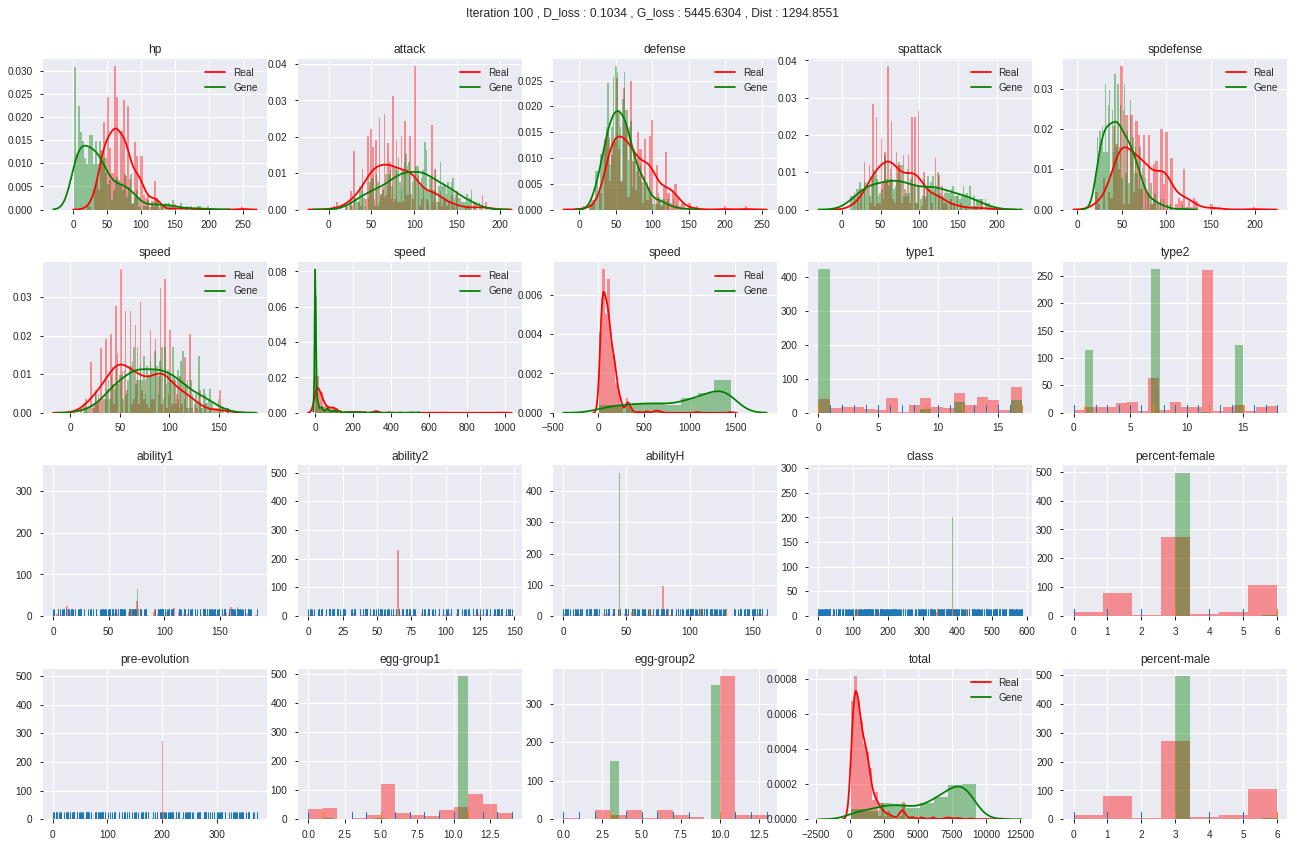

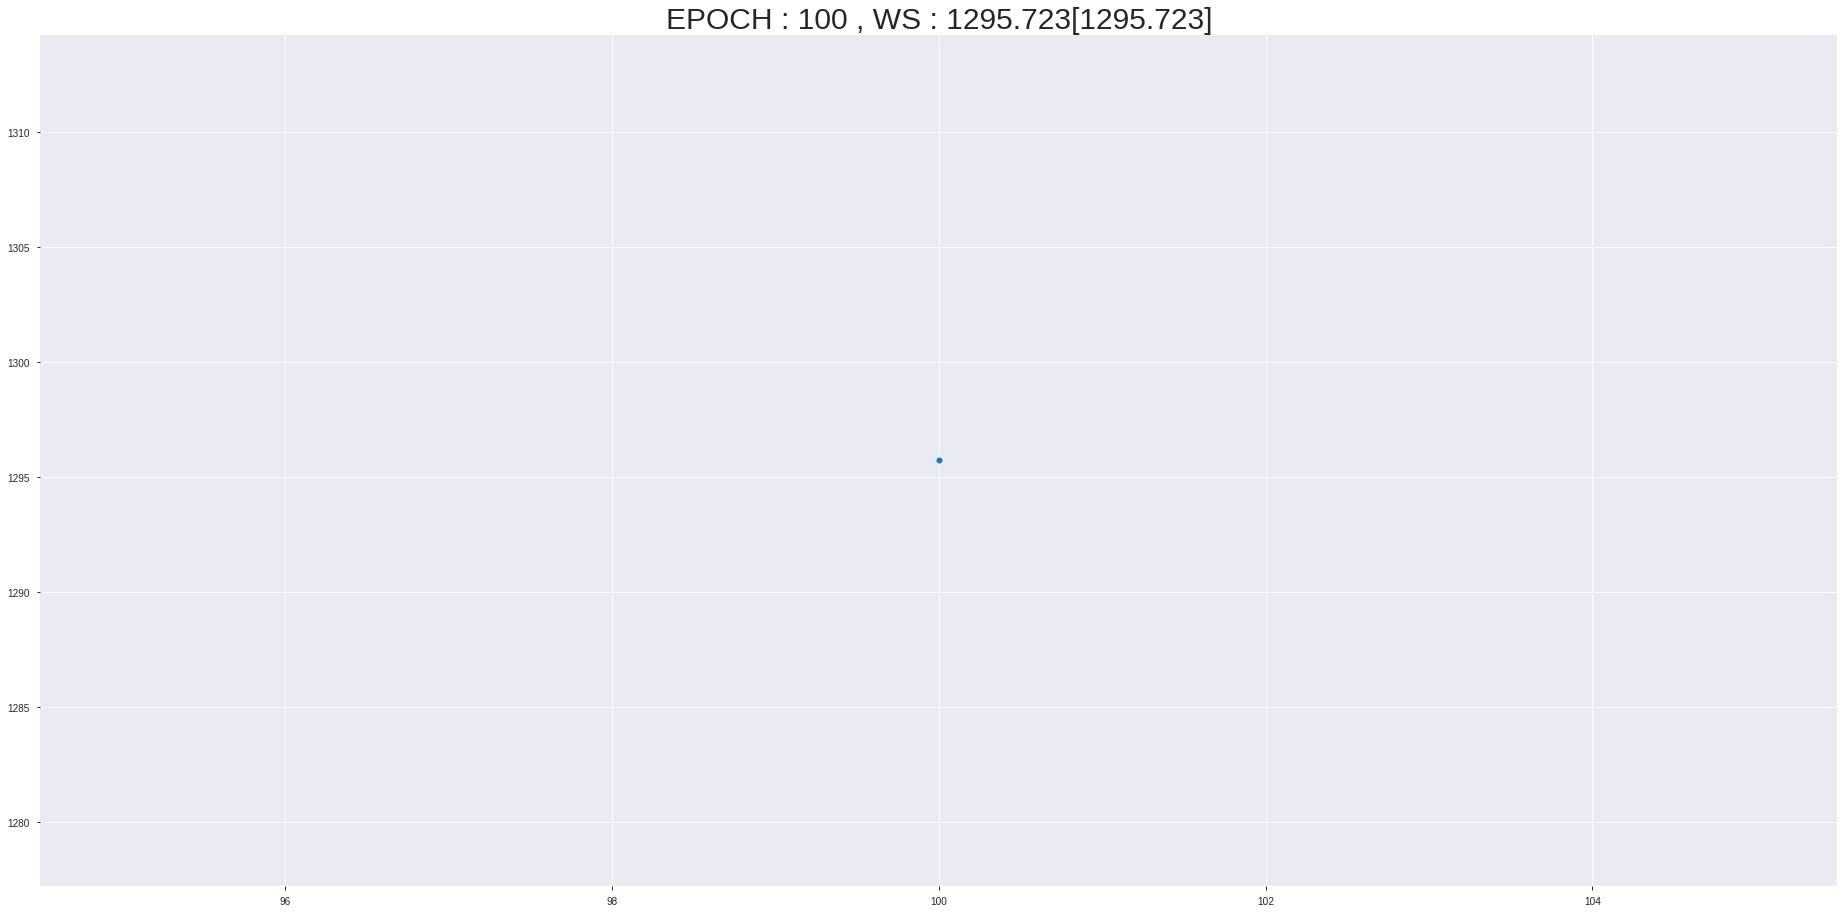

In [ ]:
if __name__ == "__main__" :
    imgs = main()

In [ ]:
imgs

* 흥미로운점은 Species 같은 경우 [-1 , 0 , 1 ] 로 minmax scaling을 한 다음에 생성을 시킴
    * 생성물은 -1 , 1 사이에서 데이터를 생성후 Round를 하여서 사용함.
    * 그래서 기대하는 것은 생성되는 것이 수치형으로 나오지만 -1 , 0 , 1 주변으로 모이면서 생성되는 것을 기대함.
    * 실제 결과도 -1 , 0 , 1 주변으로 모이는 것이 확인함.
* softmax로 생성시
    * 문제가 생기는 것은 3클래스를 생성시키는 것을 원하는데 2가지 클래스나 1개 클래스만 생성되는 경우가 지속적으로 발생함.
    * 흔히 논문에서는 wgan을 활용해서하면, 효과가 좋다고 이야기하고 있어서 진행중
    * **발견!** 선형과 섞어주니까 좀 더 고르게 나오게 되는듯
        * 더 깊게해도 잘 될까?

In [ ]:
import os
img2gif = 'convert -delay 30 -loop 0 %s {}/simulation.gif'.format(img_dir)
os.system(img2gif % ' '.join(imgs))

In [ ]:
#import os
#os.system('convert -delay 30 -loop 0 ./gan_Chrun_result/*png ./gan_Chrun_result/simulation.gif')

In [ ]:
#x_plot
#g_plot = sess.run(G_sample)
##g_plot[:,:4] = scaler.inverse_transform(g_plot[:,:4])
#g_plot = np.concatenate((g_plot[:,:4] , np.argmax(g_plot[:,4:],1)[:,np.newaxis] ), axis = 1)

```
fig, ax = plt.subplots(3,4, figsize=(14, 10))
axx = ax.flatten()
num = 0
total_dist = 0
for i in [0,1,2] :
    real_idx = x_plot[:,4] == i
    fake_idx = g_plot[:,4] == i 
    dist = 0
    for n in np.arange(4) :
        try :
            dist += was_dist(x_plot[real_idx,n], g_plot[fake_idx,n])
            total_dist += dist 
        except Exception as e :
            pass
        sns.distplot(x_plot[real_idx,n], kde_kws ={"color": "r", "label" : "Real"} , hist_kws ={"color":"r"}, ax = axx[num])
        sns.distplot(g_plot[fake_idx,n], kde_kws ={"color": "g", "label" : "Gene"} , hist_kws ={"color":"g"}, ax = axx[num])
        axx[num].set_title("{} , {}".format(i , feature[n]))
        num +=1
plt.suptitle('Iteration %d , D_loss : %.4f , G_loss : %.4f , Dist : %.4f'%(i,dloss,gloss, total_dist) )
plt.show()
```